## Import ur Lib

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision.models import convnext_tiny
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

## Import data

In [2]:
label_data = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
columns = ['patientId', 'Target']

label_data = label_data.filter(columns)
label_data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [3]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)

train_f = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
test_f = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

27204
3023


## Create dataset and visualize the imgs

In [4]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

In [6]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.paths)

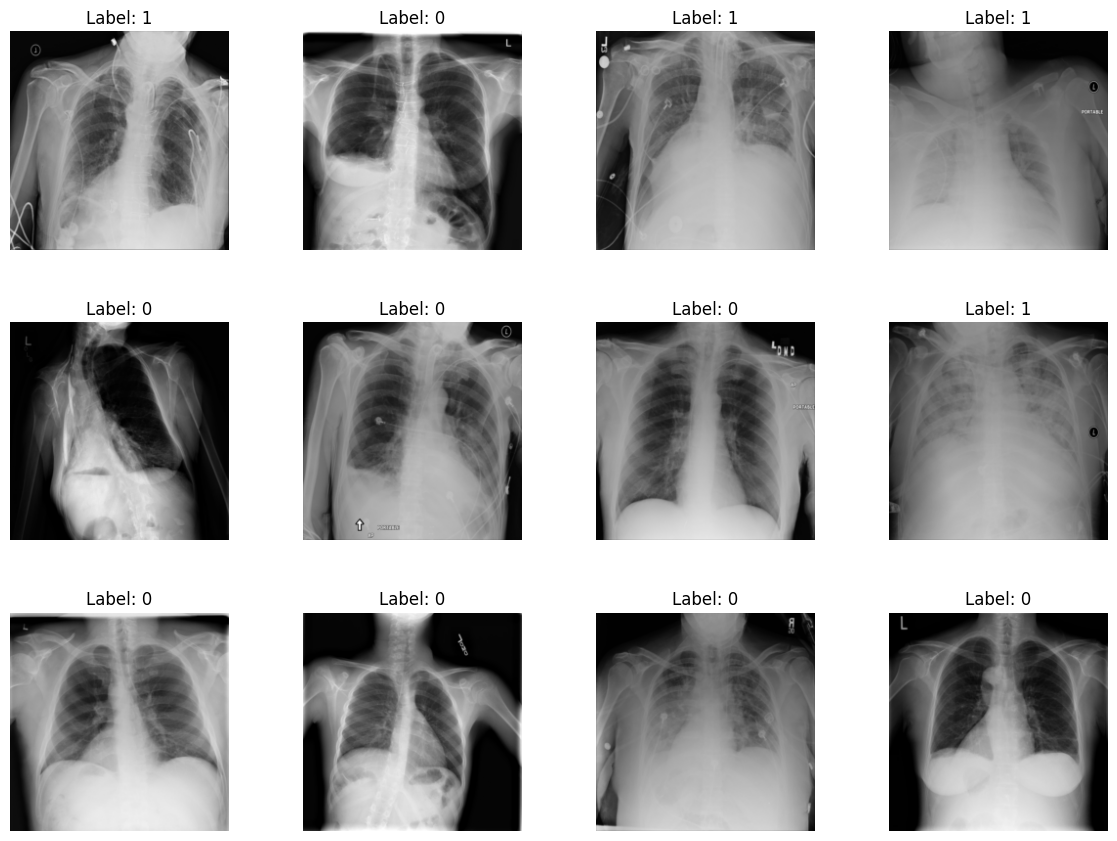

In [7]:
n_images = 12
rows, cols = 3,4
train_dataset = Dataset(train_paths, train_labels, transform=transform)
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
fig.tight_layout(pad=2.0)

for i in range(n_images):
    img, label = train_dataset[i]
    img_np = np.transpose(img, (1, 2, 0))
    ax = axes[i // cols, i % cols]
    ax.imshow(img_np)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()

In [8]:
img.shape

torch.Size([3, 224, 224])

## Dont keep the num_workers blindly always keep them max 2x of ur cpu cores

In [9]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True,num_workers=4)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False,num_workers=4)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model = convnext_tiny(pretrained=True)
model.classifier[2] = nn.Linear(in_features=768, out_features=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 231MB/s] 


## Reason for in_features = 768

In [12]:
print(model.classifier)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=2, bias=True)
)


## Train

In [13]:
num_epochs = 20
total_step = len(train_loader)
val_acc = 0
for epoch in range(num_epochs):
    model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for i, (images, labels) in enumerate(train_loader_tqdm):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            train_loader_tqdm.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images = images.to(device)
            labels = labels.to(device)

            predictions = model(images)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc_ = 100 * correct / total
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {val_acc_:.2f}%')

    if val_acc_ > val_acc:
        val_acc = val_acc_
        torch.save(model.state_dict(), "Pneumonia_convnext_tiny.pth")
        print("Model saved.")

Epoch 1/20 - Validation: 100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


Epoch: 1/20, Val_Acc: 82.60%
Model saved.


Epoch 2/20 - Validation: 100%|██████████| 24/24 [00:36<00:00,  1.52s/it]


Epoch: 2/20, Val_Acc: 81.67%


Epoch 3/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch: 3/20, Val_Acc: 83.20%
Model saved.


Epoch 4/20 - Validation: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch: 4/20, Val_Acc: 83.79%
Model saved.


Epoch 5/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch: 5/20, Val_Acc: 82.27%


Epoch 6/20 - Validation: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


Epoch: 6/20, Val_Acc: 83.76%


Epoch 7/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch: 7/20, Val_Acc: 85.68%
Model saved.


Epoch 8/20 - Validation: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch: 8/20, Val_Acc: 86.21%
Model saved.


Epoch 9/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch: 9/20, Val_Acc: 85.31%


Epoch 10/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch: 10/20, Val_Acc: 86.47%
Model saved.


Epoch 11/20 - Validation: 100%|██████████| 24/24 [00:36<00:00,  1.54s/it]


Epoch: 11/20, Val_Acc: 86.97%
Model saved.


Epoch 12/20 - Validation: 100%|██████████| 24/24 [00:36<00:00,  1.52s/it]


Epoch: 12/20, Val_Acc: 85.11%


Epoch 13/20 - Validation: 100%|██████████| 24/24 [00:37<00:00,  1.56s/it]


Epoch: 13/20, Val_Acc: 87.40%
Model saved.


Epoch 14/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch: 14/20, Val_Acc: 87.53%
Model saved.


Epoch 15/20 - Validation: 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


Epoch: 15/20, Val_Acc: 86.67%


Epoch 16/20 - Validation: 100%|██████████| 24/24 [00:39<00:00,  1.63s/it]


Epoch: 16/20, Val_Acc: 85.54%


Epoch 17/20 - Validation: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch: 17/20, Val_Acc: 87.40%


Epoch 18/20 - Validation: 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


Epoch: 18/20, Val_Acc: 87.23%


Epoch 19/20 - Validation: 100%|██████████| 24/24 [00:44<00:00,  1.84s/it]


Epoch: 19/20, Val_Acc: 86.90%


Epoch 20/20 - Validation: 100%|██████████| 24/24 [00:39<00:00,  1.66s/it]

Epoch: 20/20, Val_Acc: 85.18%


## Test

In [ ]:
model.eval()

correct = 0
total = 0  
for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')